In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import pickle
import os
import random

import torch
from torch import nn

from tensorboardX import SummaryWriter

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# SUBSAMPLING_THRESHOLD = 0.00001 # very important!!!

BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = 0.001
NUM_EPOCHES = 1

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!! unzip data.zip

['Archive:  data.zip',
 'replace data/nice_embed_tsne.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL',
 '(EOF or read error, treating as "[N]one" ...)']

In [3]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [4]:
dict_free_idx = 0
dictionary = {}

def make_trigram_seq(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    def to_dict_ind(trigram):
        if trigram in dictionary:
            return dictionary[trigram]
        
        global dict_free_idx
        dictionary[trigram] = dict_free_idx
        dict_free_idx += 1
        return dict_free_idx - 1
    
    return [to_dict_ind(cropped_seq[i:i+3]) for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_trigram_seq(seq[i:]) for i in range(3)]
    return splittings

def create_all_trigram_seqs(df):
    trigram_seqs = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        trigram_seqs.extend(seq_to3(row))
    
    return trigram_seqs

In [5]:
######################

In [6]:
all_trigram_seqs = create_all_trigram_seqs(seq_df)

print('Number of trigrams in the dataset: ', len(dictionary))
total_number_of_trigrams = sum([len(seq) for seq in all_trigram_seqs])
print('Total length of all sequences: ', total_number_of_trigrams)

def calculate_frequency(trigram_seqs):
    frequency = [0 for _ in range(len(dictionary))]
    
    total_number_of_trigrams = 0
    for seq in trigram_seqs:
        for idx in seq:
            frequency[idx] += 1
            total_number_of_trigrams += 1

    return list(map(lambda x: x / total_number_of_trigrams, frequency))
    
frequency = calculate_frequency(all_trigram_seqs)

# def probability_to_keep(idx):
#     fr = frequency[idx]
#     tmp = fr / SUBSAMPLING_THRESHOLD
#     return min(1., (np.sqrt(tmp) + 1) / tmp)

# all_trigram_seqs = [list(filter(lambda idx: np.random.binomial(1, probability_to_keep(idx)) == 1, seq)) for seq in all_trigram_seqs]
# total_number_of_trigrams = sum([len(seq) for seq in all_trigram_seqs])
# print('Total length of all sequences after subsampling: ', total_number_of_trigrams)

# frequency = calculate_frequency(all_trigram_seqs)

Number of trigrams in the dataset:  9424
Total length of all sequences:  137373126


In [7]:
######################

In [8]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            # get a random target before the center word
            for target in index_words[max(0, index - context_window_size): index]:
                yield center, target
                
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context_window_size + 1]:
                yield center, target


def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        batch = np.zeros((batch_size, 2), dtype=np.int32)
        for index in range(batch_size):
            batch[index, 0], batch[index, 1] = next(iterator)
        yield batch


def process_data(all_trigram_seqs, batch_size, skip_window):
    single_gen = generate_sample(all_trigram_seqs, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [9]:
######################

In [10]:
def create_batch_gen():
    return process_data(all_trigram_seqs, BATCH_SIZE, SKIP_WINDOW)

points_num = 0
batches_num = 0
for batch in create_batch_gen():
    points_num += len(batch)
    batches_num += 1
    
print('Number of points in the dataset: ', points_num)
print('Number of batches in the dataset: ', batches_num)

Number of points in the dataset:  3145478400
Number of batches in the dataset:  24574050


In [11]:
######################

In [14]:
class SkipGramModel(torch.nn.Module):
    def __init__(self, vocab_size, embed_size, dstr):
        super(SkipGramModel, self).__init__()
        
        self.__vocab_size = vocab_size
        self.__embed_size = embed_size
        self.__dstr = dstr
        
        self.__in_embedding = nn.Embedding(vocab_size, embed_size)
        self.__out_embedding = nn.Embedding(vocab_size, embed_size)
        self.__log_sigmoid = torch.nn.LogSigmoid()
    
    def forward(self, x):
        batch_size = x.size()[0]
        in_vectors = self.__in_embedding(x[:, 0])
        
        positive_out_vectors = self.__out_embedding(x[:, 1])
        positive_dot_prod = torch.bmm(
            in_vectors.view(batch_size, 1, self.__embed_size),
            positive_out_vectors.view(batch_size, self.__embed_size, 1)
        ).view(batch_size)
        
        
        negative_indices = self.__dstr.sample(batch_size)
        negative_out_vectors = self.__out_embedding(negative_indices)
        negative_dot_prod = torch.bmm(
            negative_out_vectors,
            in_vectors.view(batch_size, self.__embed_size, 1)
        ).view(batch_size, -1)
        
        positive_probabilities = self.__log_sigmoid(positive_dot_prod)
        negative_probabilities = self.__log_sigmoid(-negative_dot_prod)
        
        return (-torch.cat((positive_probabilities.unsqueeze(1), negative_probabilities), 1)).mean()
        
    
    def get_embeddings(self):
        with torch.no_grad():
            return self.__in_embedding(torch.tensor([i for i in range(self.__vocab_size)], dtype=torch.long))

In [15]:
VOCAB_SIZE = len(dictionary)

class UnigramDistribution:
    def __init__(self, frequency, total_number_of_trigrams, negative_samples_num):
        self.__negative_samples_num = negative_samples_num
        
        with torch.no_grad():
            tmp = torch.tensor(frequency).pow(3 / 4)
            new_frequency = tmp / tmp.sum()
            num_of_elements = (new_frequency * total_number_of_trigrams).type(torch.LongTensor) # todo: or 100M?
            
            tmp_table = []
            for idx, size in enumerate(num_of_elements.data):
                tmp_table += [idx for _ in range(size)]
                
            self.__unigram_table = torch.tensor(tmp_table)
            self.__unigram_table_size = len(self.__unigram_table)

    
    def sample(self, batch_size):
        index = torch.randint(0, self.__unigram_table_size, (batch_size, self.__negative_samples_num)).type(torch.LongTensor)
        return self.__unigram_table[index]
        
model = SkipGramModel(VOCAB_SIZE, EMBED_SIZE, UnigramDistribution(frequency, total_number_of_trigrams, NUM_SAMPLED))

In [16]:
######################

In [17]:
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass

In [18]:
def train_model(model, batch_gen_ctor, num_epoches, optimizer, writer):
    iteration_num = 0
    for epoch in range(num_epoches):
        batch_gen = batch_gen_ctor()
        for i, inputs in enumerate(batch_gen):
            optimizer.zero_grad()

            loss = model(torch.from_numpy(inputs).type(torch.long))

            loss.backward()
            optimizer.step()
            
            iteration_num += 1
            writer.add_scalar('Training loss', loss, iteration_num)
            writer.add_scalar('Epoch #{}'.format(epoch + 1), (i + 1) / batches_num, i + 1)
    
    embeddings = model.get_embeddings()
    writer.add_embedding(embeddings)
    return embeddings

In [19]:
with SummaryWriter() as writer:
    final_embed_matrix = train_model(
        model,
        create_batch_gen,
        NUM_EPOCHES,
        torch.optim.SGD(model.parameters(), lr=LEARNING_RATE),
        writer
    ).numpy()

In [20]:
######################

In [43]:
tsne = TSNE(n_components=2, random_state=42)
XX = tsne.fit_transform(final_embed_matrix)

In [22]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(dictionary, key=dictionary.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-3.583055,-1.417676,MAF
1,-0.374113,2.539454,SAE
2,-0.017270,-0.238032,DVL
3,-0.164585,2.825001,KEY
4,-2.494056,-3.506190,DRR


In [23]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('unlabeled encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

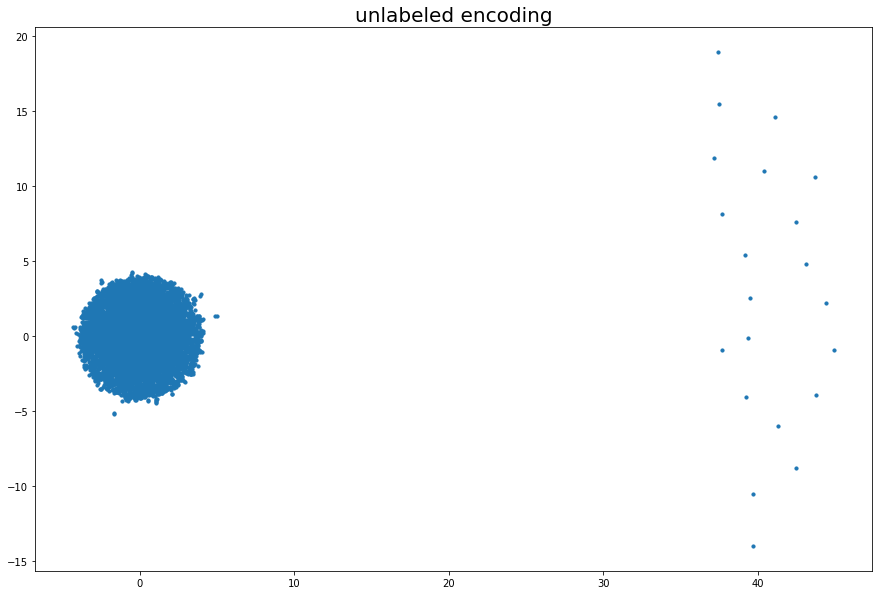

In [24]:
plot_tsne_df(tsne_df)

In [25]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [26]:
######################

In [27]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [28]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

saving data/all_acid_dicts.pickle


In [29]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,MAF,2.166667,116.482633,18.666667,147.133333
1,SAE,-0.833333,95.756400,15.333333,105.333333
2,DVL,1.500000,109.125367,19.000000,139.266667
3,KEY,-2.900000,140.153200,22.333333,166.866667
4,DRR,-4.166667,142.486267,22.666667,152.633333


In [30]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,MAF,2.166667,116.482633,18.666667,147.133333,-3.583055,-1.417676
1,SAE,-0.833333,95.756400,15.333333,105.333333,-0.374113,2.539454
2,DVL,1.500000,109.125367,19.000000,139.266667,-0.017270,-0.238032
3,KEY,-2.900000,140.153200,22.333333,166.866667,-0.164585,2.825001
4,DRR,-4.166667,142.486267,22.666667,152.633333,-2.494056,-3.506190


In [31]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

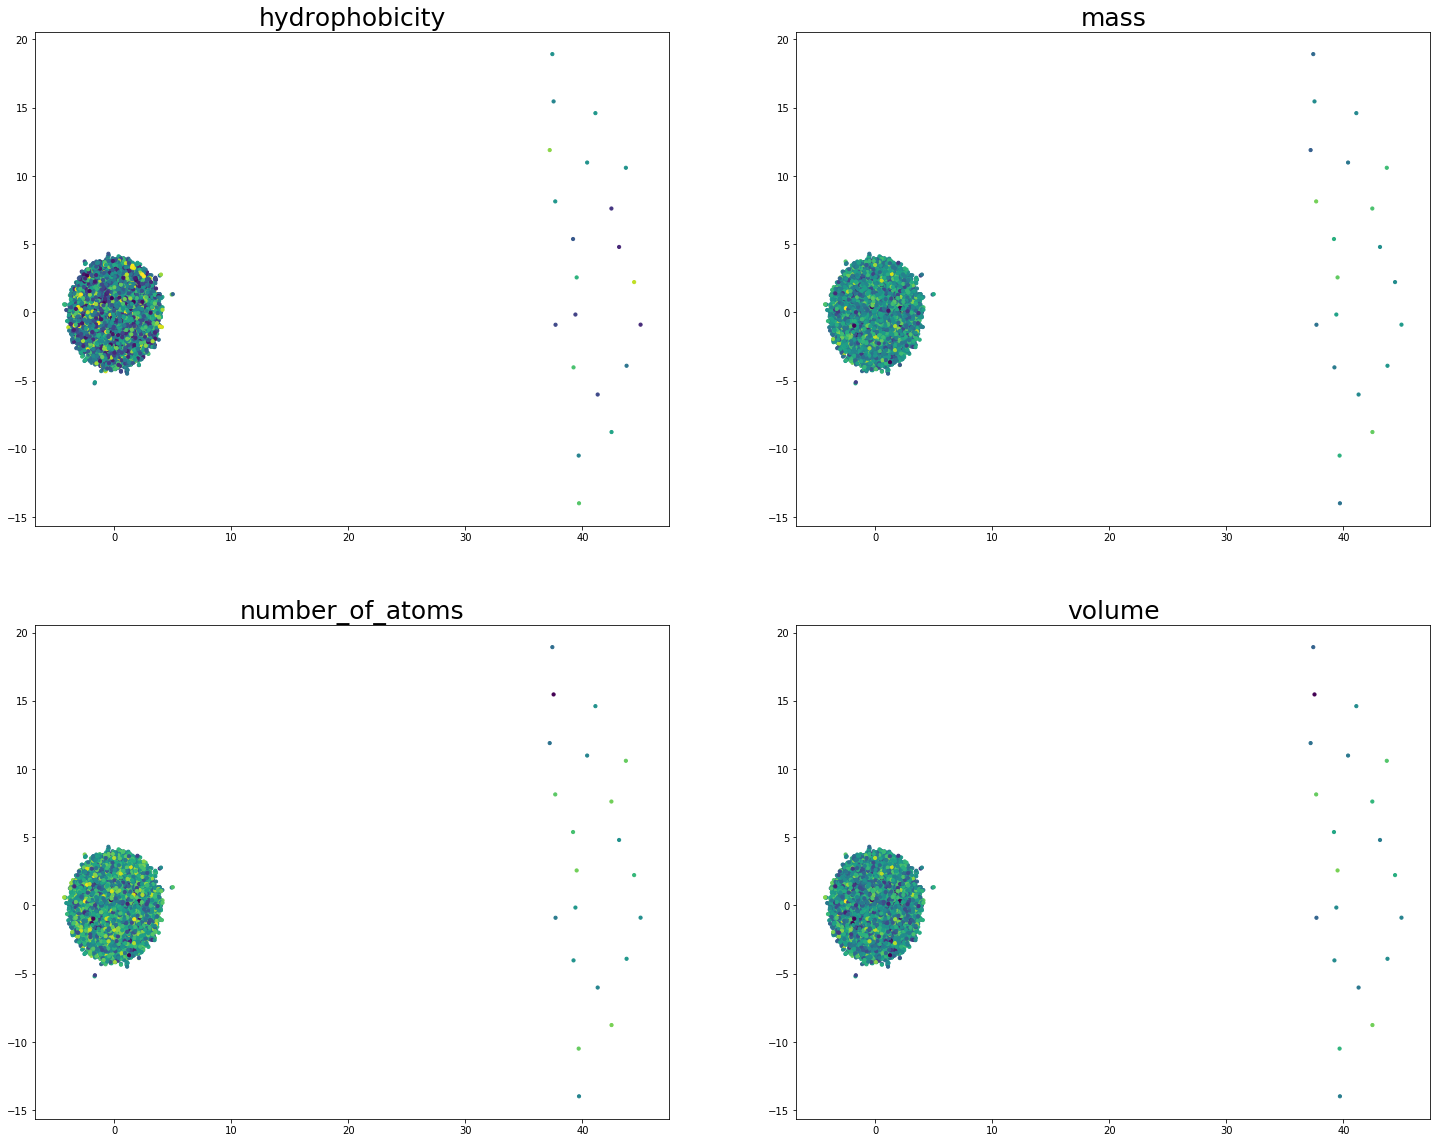

In [32]:
plot_embedding_properties(final_df)

In [33]:
######################

In [34]:
filename = 'data/nice_embed_tsne.csv'
gensim_tsne_df = pd.read_csv(filename, index_col=0)
gensim_tsne_df.columns = ['x0', 'x1', 'codone']

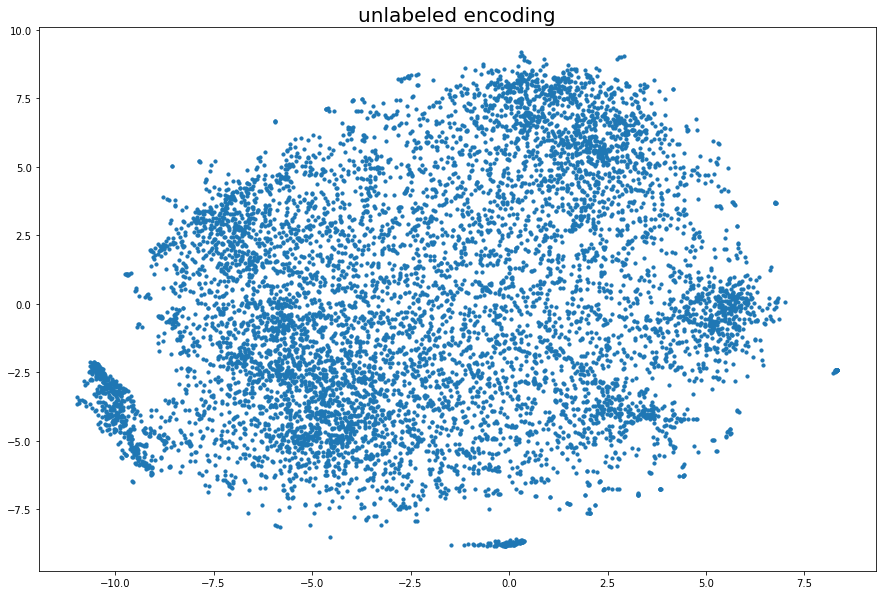

In [35]:
plot_tsne_df(gensim_tsne_df)

In [36]:
final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

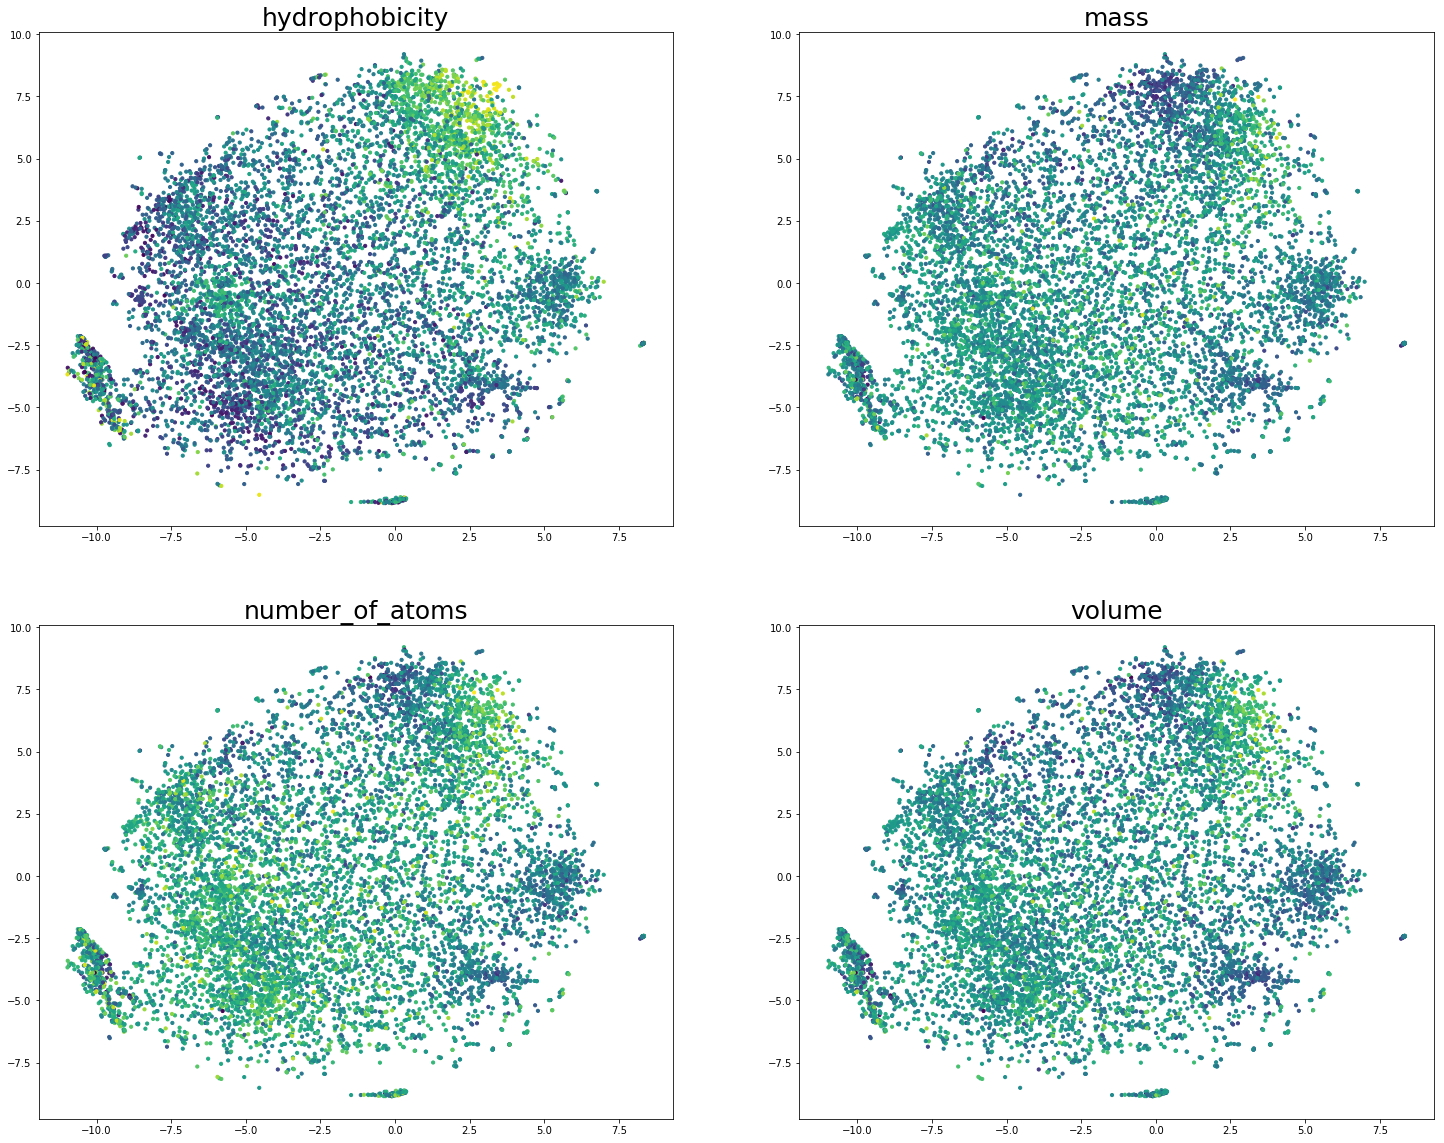

In [37]:
plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [38]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59

SyntaxError: invalid syntax (<ipython-input-38-fdda3a90776c>, line 1)